# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

In [3]:
from sklearn.metrics import mean_squared_error, make_scorer

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [5]:
import time
import warnings
warnings.filterwarnings('ignore')

In [6]:
df = pd.read_csv('/datasets/autos.csv', encoding='utf-8')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### Вывод.

- Первое, что бросается в глаза - наименования столбцов написаны не в той нотации, нужно будет привести к правильной;
- Столбцы `DateCrawled`, `DateCreated` и `LastSeen` имеют неправильный тип данных, имеет смысл преобразовать к типу `DateTime`;
- В столбцах `VehicleType`, `Gearbox`, `Model`, `FuelType` и `Repaired` имеются пропуски в данных, необходимо будет их обработать.

### Переименование столбцов.

In [8]:
df.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in df.columns]
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

### Столбцы 'date_crawled', 'date_created' и 'last_seen'.

In [9]:
df['date_crawled'] = pd.to_datetime(df['date_crawled'], format='%Y-%m-%d %H:%M:%S')
df['date_created'] = pd.to_datetime(df['date_created'], format='%Y-%m-%d %H:%M:%S')
df['last_seen'] = pd.to_datetime(df['last_seen'], format='%Y-%m-%d %H:%M:%S')

### Столбец 'price'.

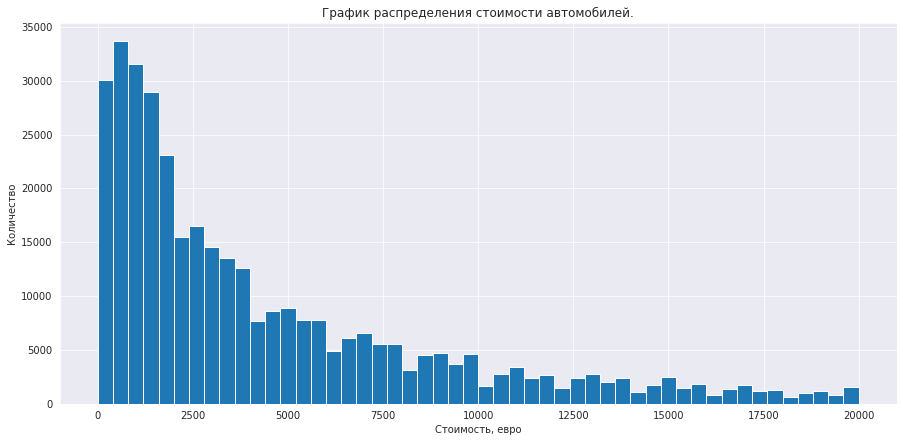

In [10]:
sns.set_style('darkgrid')
df['price'].hist(bins=50, figsize=(15, 7))
plt.title('График распределения стоимости автомобилей.')
plt.xlabel('Стоимость, евро')
plt.ylabel('Количество')
plt.show()

In [11]:
df['price'].describe()

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

In [12]:
df.query('price == 0')['price'].count()

10772

Значения, равные нулю нам мало интересны. Скорее всего это либо автомобили для равноценного обмена, либо под разбор. От таких данных лучше избавиться.

In [13]:
df = df.query('price != 0')

In [14]:
df.query('price == 0')['price'].count()

0

### Столбец 'vehicle_type'.

In [15]:
df['vehicle_type'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [16]:
df['vehicle_type'].isna().sum()

33750

Если удалить такое количество данных, мы можем потерять ценные данные в других столбцах. Можно заполнить пропуски значением `unknown`.

In [17]:
df['vehicle_type'].fillna('unknown', inplace=True)

In [18]:
df['vehicle_type'].isna().sum()

0

### Столбец 'registration_year'.

In [19]:
sorted(df['registration_year'].unique())

[1000,
 1001,
 1039,
 1111,
 1234,
 1255,
 1300,
 1400,
 1500,
 1600,
 1602,
 1800,
 1910,
 1923,
 1925,
 1927,
 1928,
 1929,
 1930,
 1931,
 1932,
 1933,
 1934,
 1935,
 1936,
 1937,
 1938,
 1940,
 1941,
 1942,
 1943,
 1944,
 1945,
 1946,
 1947,
 1948,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2066,
 2200,
 2222,
 2290,
 2500,
 2800,
 2900,
 3000,
 3200,
 3700,
 3800,
 4000,
 4100,
 4500,
 4800,
 5000,
 5300,
 5555,
 5600,
 5900,
 5911,
 6000,
 6500,
 7000,
 7100,
 7800,
 8000,
 8200,
 8500,
 8888,
 9000,
 9450,
 9999]

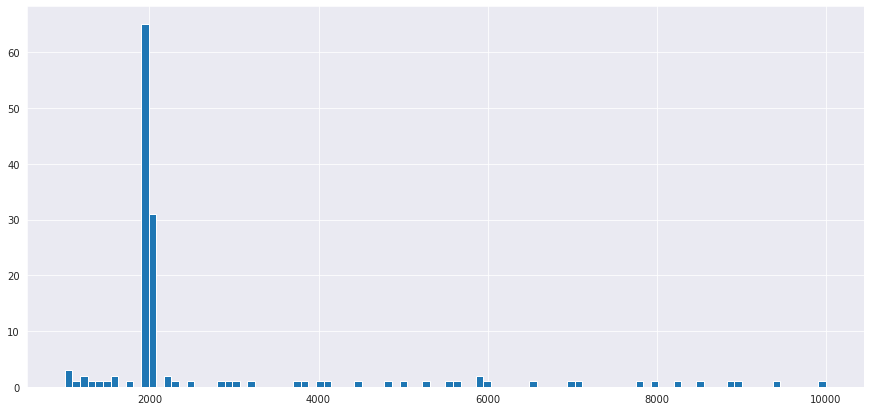

In [20]:
pd.Series(df['registration_year'].unique()).hist(bins=100, figsize=(15, 7));

Подавляющее большинство годов регистрации автомобилей лежит около 2000 года. Определим год выгрузки анкет из базы и отсортируем данные по этой дате. Также избавимся от совсем старых автомобилей.

In [21]:
df['date_crawled'].max().year

2016

In [22]:
df.query('1990 < registration_year < 2017')['registration_year'].count()

318436

In [23]:
df = df.query('1990 < registration_year < 2017')

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318436 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        318436 non-null  datetime64[ns]
 1   price               318436 non-null  int64         
 2   vehicle_type        318436 non-null  object        
 3   registration_year   318436 non-null  int64         
 4   gearbox             304367 non-null  object        
 5   power               318436 non-null  int64         
 6   model               304474 non-null  object        
 7   kilometer           318436 non-null  int64         
 8   registration_month  318436 non-null  int64         
 9   fuel_type           296111 non-null  object        
 10  brand               318436 non-null  object        
 11  repaired            262037 non-null  object        
 12  date_created        318436 non-null  datetime64[ns]
 13  number_of_pictures  318436 no

### Столбец 'gearbox'.

In [25]:
df.query('gearbox.isna()')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
16,2016-04-01 12:46:46,300,unknown,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01,0,38871,2016-04-01 12:46:46
32,2016-03-15 20:59:01,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no,2016-03-15,0,44145,2016-03-17 18:17:43
37,2016-03-28 17:50:15,1500,unknown,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,2016-03-28,0,46483,2016-03-30 09:18:02
69,2016-04-01 11:56:40,1200,coupe,2001,NaN,0,astra,150000,0,NaN,opel,NaN,2016-04-01,0,47249,2016-04-07 08:46:07
92,2016-03-16 07:56:19,250,unknown,2000,NaN,60,ka,150000,0,NaN,ford,NaN,2016-03-16,0,51427,2016-03-21 09:47:08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354288,2016-03-16 13:36:25,3300,wagon,2006,NaN,0,touran,150000,7,gasoline,volkswagen,NaN,2016-03-16,0,12057,2016-03-17 12:17:07
354305,2016-04-03 13:46:24,3500,unknown,1995,NaN,0,polo,150000,0,NaN,volkswagen,NaN,2016-04-03,0,74579,2016-04-05 12:44:38
354329,2016-03-30 20:55:30,350,small,1996,NaN,65,punto,150000,0,NaN,fiat,NaN,2016-03-30,0,25436,2016-04-07 13:50:41
354338,2016-03-31 19:52:33,180,unknown,1995,NaN,0,NaN,125000,3,petrol,opel,NaN,2016-03-31,0,41470,2016-04-06 14:18:04


Так как информация о коробке передач является очень важным параметром при обучении модели, от пропущенных значений лучше избавиться. К тому же, в данных строках присутствует множество ошибочных значений по другим столбцам.

In [26]:
df.dropna(subset=['gearbox'], inplace=True)

In [27]:
df['gearbox'].unique()

array(['manual', 'auto'], dtype=object)

### Столбец 'power'.

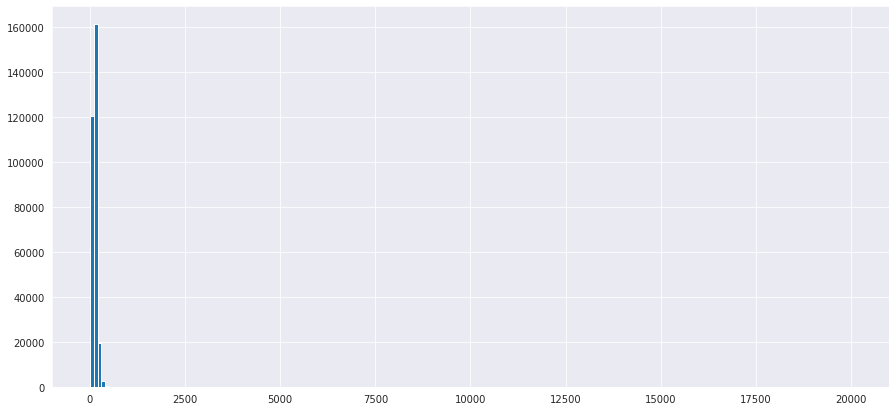

In [28]:
df['power'].hist(bins=200, figsize=(15, 7));

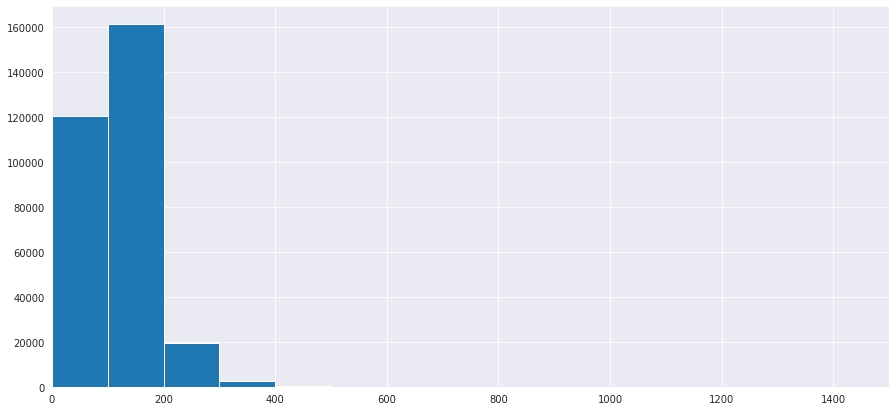

In [29]:
df['power'].hist(bins=200, figsize=(15, 7))
plt.xlim(0, 1500)
plt.show()

In [30]:
df.query('power > 500')['power'].count()

360

In [31]:
df.query('power == 0')['power'].count()

21397

По графику видно, что мощностей больше 500 почти нет. Также присутствует большое количество значений, равных нулю. Имеет смысл их удалить.

In [32]:
df = df.query('power != 0 & power <= 500')

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 282610 entries, 1 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        282610 non-null  datetime64[ns]
 1   price               282610 non-null  int64         
 2   vehicle_type        282610 non-null  object        
 3   registration_year   282610 non-null  int64         
 4   gearbox             282610 non-null  object        
 5   power               282610 non-null  int64         
 6   model               273059 non-null  object        
 7   kilometer           282610 non-null  int64         
 8   registration_month  282610 non-null  int64         
 9   fuel_type           268870 non-null  object        
 10  brand               282610 non-null  object        
 11  repaired            243886 non-null  object        
 12  date_created        282610 non-null  datetime64[ns]
 13  number_of_pictures  282610 no

### Столбец 'model'.

In [34]:
df.query('model.isna()')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
59,2016-03-29 15:48:15,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN,2016-03-29,0,53721,2016-04-06 01:44:38
81,2016-04-03 12:56:45,350,small,1997,manual,54,NaN,150000,3,NaN,fiat,yes,2016-04-03,0,45665,2016-04-05 11:47:13
135,2016-03-27 20:51:23,1450,sedan,1992,manual,136,NaN,150000,0,NaN,audi,no,2016-03-27,0,38709,2016-04-05 20:17:31
273,2016-03-29 23:38:02,1500,coupe,1994,manual,116,NaN,150000,8,NaN,audi,no,2016-03-29,0,32791,2016-04-06 20:16:34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354077,2016-03-21 08:36:18,200,small,1998,manual,37,NaN,150000,4,petrol,volkswagen,yes,2016-03-21,0,26382,2016-04-06 02:45:28
354234,2016-03-19 01:47:31,5000,sedan,2002,auto,170,NaN,150000,0,petrol,audi,no,2016-03-18,0,85221,2016-04-06 03:45:36
354245,2016-03-07 16:37:42,560,small,2001,auto,170,NaN,90000,0,petrol,fiat,yes,2016-03-07,0,55743,2016-03-12 21:45:25
354321,2016-03-15 13:52:34,9400,wagon,2007,manual,200,NaN,150000,4,gasoline,sonstige_autos,yes,2016-03-15,0,91186,2016-03-17 08:16:25


Модель авто является таким же основным фактором, как и коробка, поэтому заменять пропуски на какое-либо значение будет неправильно. Имеет смысл удалить пропуски.

In [35]:
df.dropna(subset=['model'], inplace=True)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 273059 entries, 2 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        273059 non-null  datetime64[ns]
 1   price               273059 non-null  int64         
 2   vehicle_type        273059 non-null  object        
 3   registration_year   273059 non-null  int64         
 4   gearbox             273059 non-null  object        
 5   power               273059 non-null  int64         
 6   model               273059 non-null  object        
 7   kilometer           273059 non-null  int64         
 8   registration_month  273059 non-null  int64         
 9   fuel_type           261552 non-null  object        
 10  brand               273059 non-null  object        
 11  repaired            237374 non-null  object        
 12  date_created        273059 non-null  datetime64[ns]
 13  number_of_pictures  273059 no

### Столбец 'kilometer'.

In [37]:
df['kilometer'].describe()

count    273059.000000
mean     128547.218733
std       36320.024123
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

С этим столбцом все в порядке.

### Столбец 'registration_month'.

In [38]:
sorted(df['registration_month'].unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [39]:
df['registration_month'].value_counts()

3     28424
6     25566
4     23904
5     23770
7     21944
10    21539
12    19867
11    19783
9     19696
1     18753
8     18443
2     17593
0     13777
Name: registration_month, dtype: int64

Данные в этом столбце не влияют на цену. При удалении некорректных данных, мы можем потерять важную информацию в других столбцах, поэтому заменим нули на среднее значение.

In [40]:
df.loc[df['registration_month'] == 0, 'registration_month'] = 6

In [41]:
sorted(df['registration_month'].unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

### Столбец 'fuel_type'.

In [42]:
df['fuel_type'].unique()

array(['gasoline', 'petrol', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [43]:
df['fuel_type'].isna().sum()

11507

Так как тип топлива зависит от типа двигателя, заполнять пропуски каким-либо определенным значением будет не совсем корректно. Поэтому заменим отсутствующие значения на `other`.

In [44]:
df['fuel_type'].fillna('other', inplace=True)

In [45]:
df['fuel_type'].unique()

array(['gasoline', 'petrol', 'other', 'lpg', 'hybrid', 'cng', 'electric'],
      dtype=object)

### Столбец 'brand'.

In [46]:
df['brand'].unique()

array(['jeep', 'volkswagen', 'skoda', 'bmw', 'peugeot', 'ford', 'mazda',
       'nissan', 'renault', 'mercedes_benz', 'seat', 'honda', 'fiat',
       'opel', 'mini', 'smart', 'hyundai', 'audi', 'alfa_romeo', 'subaru',
       'volvo', 'mitsubishi', 'kia', 'lancia', 'citroen', 'toyota',
       'chevrolet', 'dacia', 'suzuki', 'daihatsu', 'chrysler', 'jaguar',
       'daewoo', 'rover', 'porsche', 'saab', 'land_rover', 'lada',
       'trabant'], dtype=object)

В этом столбце проблем нет.

### Столбец 'repaired'.

In [47]:
df['repaired'].unique()

array([nan, 'no', 'yes'], dtype=object)

In [48]:
df['repaired'].isna().sum()

35685

Продавцы могут намеренно не указывать был автомобиль в ремонте или нет. Предположение, что все пропуски - это отсутствие ремонта, может быть ошибочным. Такое количество строк лучше не удалять, а заменить на значение `unknown`.

In [49]:
df['repaired'].fillna('unknown', inplace=True)

In [50]:
df['repaired'].unique()

array(['unknown', 'no', 'yes'], dtype=object)

### Столбец 'number_of_pictures'.

In [51]:
df['number_of_pictures'].describe()

count    273059.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: number_of_pictures, dtype: float64

В столбце содержатся только нули. Пользы этот столбец не несет. Его можно удалить.

In [52]:
df = df.drop('number_of_pictures', axis=1)

In [53]:
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'postal_code', 'last_seen'],
      dtype='object')

### Столбец 'postal_code'.

In [54]:
df['postal_code'].describe()

count    273059.000000
mean      51334.872083
std       25746.594942
min        1067.000000
25%       31008.000000
50%       50374.000000
75%       72131.000000
max       99998.000000
Name: postal_code, dtype: float64

Проблем с этим столбцом также не наблюдается.

### Корреляция параметров.

Посмотрим, как взаимосвязаны данные после проведения предобработки.

In [55]:
df.corr()

,price,registration_year,power,kilometer,registration_month,postal_code
price,1.000000,0.631893,0.513408,-0.402917,0.016373,0.063654
registration_year,0.631893,1.000000,0.136084,-0.431737,-0.006448,0.035182
power,0.513408,0.136084,1.000000,0.099961,0.022696,0.053588
kilometer,-0.402917,-0.431737,0.099961,1.000000,0.001599,-0.013015
registration_month,0.016373,-0.006448,0.022696,0.001599,1.000000,-0.007938
postal_code,0.063654,0.035182,0.053588,-0.013015,-0.007938,1.000000


Можно увидеть сильную положительную зависимость стоимости от года регистрации автомобиля и его мощности. В то же время наблюдается сильная отрицательная зависимость от пробега.

### Вывод.

Была проведена предобработка данных. В ходе нее было проделано следующее:
- Наименования столбцов были приведены к "змеиной нотации";
- Столбцы `date_crawled`, `date_created` и `last_seen` были приведены к типу `DateTime`;
- В столбце `price` были удалены выбросы - нулевые значения;
- В столбце `vehicle_type` обработаны пропущенные значения. Было принято решение не удалять их, а заполнить значением `unknown`;
- В столбце `registration_year` были удалены некорректные значения, удалены автомобили до 1990 года и сделан срез данных по годам выпуска автомобилей, не превышающим год выгрузки данных из базы;
- В столбце `gearbox` были удалены пропущенные значения;
- В столбце `power` были удалены строки, в которых значение мощности превышало 500. Помимо этого были также удалены нулевые значения.
- В столбце `model` были удалены пропущенные значения;
- В столбце `registration_month` были обработаны нулевые значения и принято решение заменить их на среднее значение, равное 6;
- В столбце `fuel_type` пропуски были заменены значение `other`;
- В столбце `repaired` также были заменены пропуски на значение `unknown`;
- Столбец `number_of_pictures` был удален как не несущий никакой информации, так как все значения в нем были равны нулю.

## Кодирование данных

### Удаление неинформативных столбцов.

Перед тем, как закодировать данные имеет смысл выделить среди них действительно важные для обучения моделей и избавиться от бесполезных.

In [56]:
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,postal_code,last_seen
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01,67112,2016-04-05 18:18:39


In [57]:
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'postal_code', 'last_seen'],
      dtype='object')

In [58]:
columns = ['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
           'model', 'kilometer', 'fuel_type', 'brand', 'repaired']

Создадим новый датафрейм с данными для обучения.

In [59]:
df_train = df[columns]
df_train.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no


In [60]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 273059 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              273059 non-null  int64 
 1   vehicle_type       273059 non-null  object
 2   registration_year  273059 non-null  int64 
 3   gearbox            273059 non-null  object
 4   power              273059 non-null  int64 
 5   model              273059 non-null  object
 6   kilometer          273059 non-null  int64 
 7   fuel_type          273059 non-null  object
 8   brand              273059 non-null  object
 9   repaired           273059 non-null  object
dtypes: int64(4), object(6)
memory usage: 22.9+ MB


Не будет лишним сбросить индексы после проведения предобработки.

In [61]:
df_train = df_train.reset_index(drop=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273059 entries, 0 to 273058
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              273059 non-null  int64 
 1   vehicle_type       273059 non-null  object
 2   registration_year  273059 non-null  int64 
 3   gearbox            273059 non-null  object
 4   power              273059 non-null  int64 
 5   model              273059 non-null  object
 6   kilometer          273059 non-null  int64 
 7   fuel_type          273059 non-null  object
 8   brand              273059 non-null  object
 9   repaired           273059 non-null  object
dtypes: int64(4), object(6)
memory usage: 20.8+ MB


### Разделение на основную выборку и целевой параметр.

In [62]:
target = df_train['price']
features = df_train.drop(['price'], axis=1)

In [63]:
print(features.shape)
print(target.shape)

(273059, 9)
(273059,)


### Разделение данных на тренировочную и тестовую выборки.

In [64]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12345)

In [65]:
print('train:', features_train.shape, target_train.shape)
print('test:', features_test.shape, target_test.shape)

train: (204794, 9) (204794,)
test: (68265, 9) (68265,)


### Кодирование признаков.

Данные разделили, выбираем только категориальные признаки и кодируем их с помощью `OrdinalEncoder`.

In [66]:
features_train.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
169466,wagon,2000,manual,116,golf,150000,gasoline,volkswagen,no
116627,small,2006,manual,80,polo,100000,gasoline,volkswagen,no
197071,convertible,2012,manual,102,other,60000,petrol,renault,no
121801,sedan,2005,auto,200,golf,150000,petrol,volkswagen,no
103399,small,2000,manual,54,micra,150000,petrol,nissan,no


In [67]:
features_train.columns

Index(['vehicle_type', 'registration_year', 'gearbox', 'power', 'model',
       'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

Выбираем только категориальные признаки.

In [68]:
columns = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

In [69]:
encoder = OrdinalEncoder()
encoder.fit(features_train[columns])

OrdinalEncoder()

In [70]:
features_train[columns] = encoder.transform(features_train[columns])
features_test[columns] = encoder.transform(features_test[columns])

features_train.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
169466,8.0,2000,1.0,116,116.0,150000,2.0,37.0,0.0
116627,5.0,2006,1.0,80,173.0,100000,2.0,37.0,0.0
197071,1.0,2012,1.0,102,166.0,60000,6.0,27.0,0.0
121801,4.0,2005,0.0,200,116.0,150000,6.0,37.0,0.0
103399,5.0,2000,1.0,54,151.0,150000,6.0,23.0,0.0


### Масштабирование данных.

В нашем датасете данные имеют разный масштаб. Для дальнейшей работы приведем их к одному масштабу с помощью `StandardScaler`.

In [71]:
scaler = StandardScaler()
scaler.fit(features_train)

StandardScaler()

In [72]:
features_train = pd.DataFrame(scaler.transform(features_train), columns=features_train.columns)
features_test = pd.DataFrame(scaler.transform(features_test), columns=features_test.columns)

features_train.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,1.412698,-0.644115,0.503303,-0.102662,0.126590,0.591433,-1.461674,1.277815,-0.502643
1,0.171484,0.470569,0.503303,-0.781044,0.935172,-0.784464,-1.461674,1.277815,-0.502643
2,-1.483468,1.585253,0.503303,-0.366477,0.835873,-1.885182,0.719225,0.512200,-0.502643
3,-0.242254,0.284788,-1.986875,1.480229,0.126590,0.591433,0.719225,1.277815,-0.502643
4,0.171484,-0.644115,0.503303,-1.270987,0.623088,0.591433,0.719225,0.205954,-0.502643


## Обучение моделей

In [76]:
def rmse(target, predict):
    return mean_squared_error(target, predict) ** 0.5

rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [77]:
def best_hyperparams(estimator, grid_space):
    grid = GridSearchCV(estimator=estimator,
                        param_grid=grid_space,
                        cv=3,
                        scoring=rmse_scorer,
                        verbose=100)

    grid.fit(features_train, target_train)
    
    return grid

### Случайный лес.

In [78]:
rf_best_params = (100, 19)

In [79]:
# grid_space = {'n_estimators': [10, 40, 70, 100],
#               'max_depth': [i for i in range(1, 21, 2)],}

In [80]:
# %%time

# grid = best_hyperparams(RandomForestRegressor(random_state=12345), grid_space)

In [81]:
# print('best params:', grid.best_params_)
# print('best rmse:', abs(grid.best_score_))

### CatBoost.

In [82]:
cb_best_params = (500, 9)

In [83]:
# grid_space = {'n_estimators': [i for i in range(100, 510, 50)],
#               'max_depth': [i for i in range(1, 11)],}

In [84]:
# %%time

# grid = best_hyperparams(CatBoostRegressor(random_state=12345, learning_rate=0.5, verbose=100), grid_space)

In [85]:
# print('best params:', grid.best_params_)
# print('best rmse:', abs(grid.best_score_))

### LightGBM.

In [86]:
lgbm_best_params = (500, 8)

In [87]:
# %%time

# grid = best_hyperparams(LGBMRegressor(random_state=12345, learning_rate=0.5), grid_space)

In [88]:
# print('best params:', grid.best_params_)
# print('best rmse:', abs(grid.best_score_))

In [89]:
best_params = pd.DataFrame([rf_best_params, cb_best_params, lgbm_best_params],
                          index=['random_forest', 'catboost', 'lightgbm'],
                          columns=['n_estimators', 'max_depth'])

best_params

,n_estimators,depth
random_forest,100,19
catboost,500,9
lightgbm,500,8


### Вывод.

Были обучены три модели машинного обучения: `RandomForest`, `CatBoost` и `LightGBM`. Для всех моделей были подобраны оптимальные гиперпараметры:
- RandomForest: `n_estimators` = 100, `max_depth` = 19;
- CatBoost: `n_estimators` = 500, `max_depth` = 9;
- LightGBM: `n_estimators` = 500, `max_depth` = 8.

## Анализ моделей

In [90]:
def analyze_parameters(model):
    scores = cross_val_score(model, features_train, target_train, cv=5, scoring=rmse_scorer)
    final_score = abs(scores.mean())
    
    start = time.time()
    
    model.fit(features_train, target_train)
    
    time_train = time.time() - start
    
    start = time.time()
    
    model.predict(features_train)
    
    time_pred = time.time() - start
    
    return final_score, time_train, time_pred

In [91]:
column = ['RMSE', 'train_time, s', 'pred_time, s']
index = ['random_forest', 'catboost', 'lightgbm']

comp_table = []

### Случайный лес.

In [92]:
%%time

comp_table.append(analyze_parameters(RandomForestRegressor(random_state=12345, n_estimators=100, max_depth=19)))
comp_table

CPU times: user 3min 23s, sys: 2.21 s, total: 3min 25s
Wall time: 3min 26s


[(1505.0662364362947, 39.217299938201904, 5.005403518676758)]

### CatBoost.

In [93]:
%%time

comp_table.append(analyze_parameters(CatBoostRegressor(random_state=12345, loss_function='RMSE', verbose=100,
                                                       learning_rate=0.5, max_depth=9, n_estimators=500)))
comp_table

0:	learn: 3136.2635473	total: 84.4ms	remaining: 42.1s
100:	learn: 1382.0895453	total: 3.15s	remaining: 12.4s
200:	learn: 1290.9851178	total: 6.17s	remaining: 9.18s
300:	learn: 1243.1776558	total: 8.93s	remaining: 5.9s
400:	learn: 1206.6157932	total: 11.9s	remaining: 2.93s
499:	learn: 1179.8472490	total: 14.8s	remaining: 0us
0:	learn: 3144.6148300	total: 32.2ms	remaining: 16.1s
100:	learn: 1387.1010729	total: 2.93s	remaining: 11.6s
200:	learn: 1299.3468508	total: 5.85s	remaining: 8.7s
300:	learn: 1248.5750034	total: 8.74s	remaining: 5.78s
400:	learn: 1213.3169943	total: 11.6s	remaining: 2.87s
499:	learn: 1186.8628040	total: 14.4s	remaining: 0us
0:	learn: 3126.8695819	total: 28.4ms	remaining: 14.1s
100:	learn: 1383.4726170	total: 2.85s	remaining: 11.3s
200:	learn: 1297.7912469	total: 5.63s	remaining: 8.37s
300:	learn: 1243.3486850	total: 8.44s	remaining: 5.58s
400:	learn: 1206.8384401	total: 11.3s	remaining: 2.8s
499:	learn: 1177.3900943	total: 14.2s	remaining: 0us
0:	learn: 3103.1046277

[(1505.0662364362947, 39.217299938201904, 5.005403518676758),
 (1462.20626406599, 18.75302219390869, 0.32926487922668457)]

### LightGBM.

In [94]:
%%time

comp_table.append(analyze_parameters(LGBMRegressor(random_state=12345, learning_rate=0.5, max_depth=8, n_estimators=500)))
comp_table

CPU times: user 48min 19s, sys: 20.1 s, total: 48min 39s
Wall time: 48min 57s


[(1505.0662364362947, 39.217299938201904, 5.005403518676758),
 (1462.20626406599, 18.75302219390869, 0.32926487922668457),
 (1474.5629649578468, 11.810840845108032, 4.708601951599121)]

In [95]:
pd.DataFrame(comp_table, index=index, columns=column)

,RMSE,"train_time, s","pred_time, s"
random_forest,1505.066236,39.217300,5.005404
catboost,1462.206264,18.753022,0.329265
lightgbm,1474.562965,11.810841,4.708602


### Вывод.

- По целевому показателю `rmse` все модели показали примерно одинаковый результат, но лучше всего - `CatBoost`;
- По времени обучения самой быстрой оказалась модель `LightGBM`;
- По скорости предсказания `CatBoost` снова оказалась лучшей.

Исходя из вышеперечисленного, самым оптимальным выбором будет модель `CatBoost`. Ее возьмем для финального тестирования.

## Тестирование лучшей модели

In [96]:
model = CatBoostRegressor(random_state=12345, loss_function='RMSE', verbose=100,
                          learning_rate=0.5, max_depth=9, n_estimators=500)

model.fit(features_train, target_train)

0:	learn: 3103.2301725	total: 35.3ms	remaining: 17.6s
100:	learn: 1394.1559773	total: 3.34s	remaining: 13.2s
200:	learn: 1310.6102384	total: 6.73s	remaining: 10s
300:	learn: 1261.3628415	total: 10.2s	remaining: 6.75s
400:	learn: 1227.3522728	total: 13.6s	remaining: 3.37s
499:	learn: 1201.6476316	total: 16.9s	remaining: 0us


In [97]:
predictions = model.predict(features_test)
print('rmse:', rmse(target_test, predictions))

rmse: 1449.9432950276473


Полученное значение метрики `rmse` соответствует заявленным требованиям.

## Вывод.

Было проведено исследование, целью которого являлось определить, какая модель машинного обучения лучше всего подходит заказчику, исходя из его критериев:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

В нашем распоряжении были данные, которые требовали предварительной обработки. Результаты этого процесса описаны в пункте `1.18`. Помимо этого была исследована корреляция параметров с целевым признаком (стоимость). Результаты получились следующие:
- Заметна сильная положительная зависимость `стоимости` автомобиля от `года регистрации` и `мощности`;
- В то же время можно заметить, что `пробег` имеет сильное отрицательное влияние на `стоимость` автомобиля.

На обучение были взяты три модели: `RandomForest`, `CatBoost` и `LightGBM`. Для каждой из них были подобраны оптимальные гиперпараметры:
- RandomForest: `n_estimators` = 100, `max_depth` = 19;
- CatBoost: `n_estimators` = 500, `max_depth` = 9;
- LightGBM: `n_estimators` = 500, `max_depth` = 8.

В дальнейшем они были обучены с использованием этих гиперпараметров. Результаты получились следующие:
- По целевому показателю `rmse` все модели показали примерно одинаковый результат, но лучше всего - `CatBoost`;
- По времени обучения самой быстрой оказалась модель `LightGBM`;
- По скорости предсказания `CatBoost` снова оказалась лучшей.

Исходя из вышеперечисленного, самым оптимальным выбором будет модель `CatBoost`. Несмотря на то, что обучается она немного дольше, чем `LightGBM`, по остальным показателям она является наилучшей. Финальное тестирование также показало, что модель отвечает требованиям заказчика.